In [ ]:
import torch, os, random, numpy as np
print("Torch:", torch.__version__)
torch.backends.cudnn.benchmark = True  # Speeds up when input dimensions are fixed
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

Tue Nov  4 01:43:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip -q install segmentation-models-pytorch==0.3.3 torchmetrics==1.4.0 albumentations==1.4.4 opencv-python==4.10.0.84


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.4 MB/s eta 0:00:00


In [ ]:
import os, re, shutil, subprocess
from pathlib import Path

ARC = Path("/content/model_development_dataset.zip")   # Fixed path where you uploaded the file
DST = Path("/content/datasets/model_dev")
shutil.rmtree(DST, ignore_errors=True)
DST.mkdir(parents=True, exist_ok=True)

assert ARC.exists(), f"File not found: {ARC}, please confirm the file name and path"

def run(cmd, check=True, tail=4000):
    print("→", " ".join(map(str, cmd)))
    res = subprocess.run(cmd, text=True, capture_output=True)
    if res.stdout: print(res.stdout[-tail:])
    if res.returncode != 0:
        if res.stderr: print(res.stderr[-tail:])
        if check: raise RuntimeError(f"Command failed: {' '.join(map(str, cmd))}")
    return res

# If .z01 multi-volume files exist alongside zip, prioritize 7z
z01 = ARC.with_suffix(".z01")
if z01.exists():
    print("Detected multi-volume .z01 set")
    try:
        subprocess.run(["7z"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except FileNotFoundError:
        print("Installing p7zip-full ...")
        run(["apt-get","update","-y"])
        run(["apt-get","install","-y","p7zip-full"])
    run(["7z","x","-y",str(z01), f"-o{str(DST)}"])
else:
    print("Single zip detected")
    run(["unzip","-q",str(ARC), "-d", str(DST)])

print("After extract, top-level:")
for p in sorted(DST.iterdir()):
    print("  ", p)

Single zip detected
→ unzip -q /content/model_development_dataset.zip -d /content/datasets/model_dev
After extract, top-level:
   /content/datasets/model_dev/model_development_dataset


In [ ]:
import os
from pathlib import Path

def find_dataset_root(base_dir: str|Path):
    base = Path(base_dir)
    patterns = [
        ("train/img","val/img","train/mask","val/mask"),
        ("train/images","val/images","train/masks","val/masks"),
        ("images/train","images/val","masks/train","masks/val"),
        ("img/train","img/val","mask/train","mask/val"),
        ("train/images","val/images","train/labels","val/labels"),
        ("train/images","val/images","train/annotation","val/annotation"),
        ("train/images","val/images","train/annotations","val/annotations"),
        ("images/train","images/val","labels/train","labels/val"),
    ]
    for root, dirs, files in os.walk(base):
        rp = Path(root)
        for a,b,c,d in patterns:
            if (rp/a).exists() and (rp/b).exists() and (rp/c).exists() and (rp/d).exists():
                return str(rp)
    return None

DATA_ROOT = find_dataset_root(DST)
assert DATA_ROOT is not None, f"Could not find train/val structure. Please check folder naming in {DST}"
print("✅ DATA_ROOT:", DATA_ROOT)

✅ DATA_ROOT: /content/datasets/model_dev/model_development_dataset


In [ ]:
import cv2, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

class PVSegDataset(Dataset):
    def __init__(self, img_dir, msk_dir, transform=None, id_whitelist=None,
                 mask_suffixes=("", "_mask", "_label", "-label", "_gt")):
        self.img_dir = Path(img_dir); self.msk_dir = Path(msk_dir)
        self.transform = transform
        self.id_whitelist = set(id_whitelist) if id_whitelist else None
        self.mask_suffixes = mask_suffixes
        exts = [".png",".jpg",".jpeg",".tif",".tiff",".bmp"]
        imgs = sorted([p for p in self.img_dir.glob("*") if p.suffix.lower() in exts])
        self.samples = []
        for ip in imgs:
            stem = ip.stem
            if self.id_whitelist and stem not in self.id_whitelist:
                continue
            found = None
            for suf in self.mask_suffixes:
                for ext in exts:
                    cand = self.msk_dir / f"{stem}{suf}{ext}"
                    if cand.exists(): found = cand; break
                if found is not None: break
            if found is not None:
                self.samples.append((ip, found))
        if not self.samples:
            raise RuntimeError(f"No image-mask pairs in {img_dir} and {msk_dir}")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        ip, mp = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(str(ip), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
        if msk.ndim == 3: msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
        msk = (msk > 127).astype(np.uint8)  # Foreground=1, Background=0
        if self.transform:
            out = self.transform(image=img, mask=msk)
            img, msk = out["image"], out["mask"].long()
        else:
            img = ToTensorV2()(image=img)["image"]; msk = torch.from_numpy(msk).long()
        return img, msk, ip.name

def get_train_transform(size=256):
    return A.Compose([
        A.LongestMaxSize(max_size=size),
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

def get_val_transform(size=256):
    return A.Compose([
        A.LongestMaxSize(max_size=size),
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

from pathlib import Path
rootp = Path(DATA_ROOT)
candidates = [
    {"train_images": rootp/"images"/"train", "val_images": rootp/"images"/"val",
     "train_masks": rootp/"masks"/"train",  "val_masks": rootp/"masks"/"val"},
    {"train_images": rootp/"train"/"images","val_images": rootp/"val"/"images",
     "train_masks": rootp/"train"/"masks",  "val_masks": rootp/"val"/"masks"},
    {"train_images": rootp/"train"/"img",   "val_images": rootp/"val"/"img",
     "train_masks": rootp/"train"/"mask",   "val_masks": rootp/"val"/"mask"},
    {"train_images": rootp/"img"/"train",   "val_images": rootp/"img"/"val",
     "train_masks": rootp/"mask"/"train",   "val_masks": rootp/"mask"/"val"},
    {"train_images": rootp/"images"/"train","val_images": rootp/"images"/"val",
     "train_masks": rootp/"labels"/"train", "val_masks": rootp/"labels"/"val"},
    {"train_images": rootp/"images"/"train","val_images": rootp/"images"/"val",
     "train_masks": rootp/"annotations"/"train", "val_masks": rootp/"annotations"/"val"},
]
ds_paths = None
for o in candidates:
    if all(Path(p).exists() for p in o.values()):
        ds_paths = o; break
assert ds_paths is not None, "Did not match image and annotation folders, please check naming"
print(ds_paths)

# Key hyperparameters
IMG_SIZE   = 256      # Start with 256 for quick testing and comparison. Can be changed to 400 or 512 later for retraining.
BATCH_SIZE = 12
NUM_WORKERS= 4

train_ds = PVSegDataset(ds_paths["train_images"], ds_paths["train_masks"], transform=get_train_transform(IMG_SIZE))
val_ds   = PVSegDataset(ds_paths["val_images"],   ds_paths["val_masks"],   transform=get_val_transform(IMG_SIZE))
print(f"Pairs -> train: {len(train_ds)} | val: {len(val_ds)}")

loader_kwargs = dict(batch_size=BATCH_SIZE, pin_memory=True)
if NUM_WORKERS > 0:
    loader_kwargs.update(dict(num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2))
train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)

{'train_images': PosixPath('/content/datasets/model_dev/model_development_dataset/train/img'), 'val_images': PosixPath('/content/datasets/model_dev/model_development_dataset/val/img'), 'train_masks': PosixPath('/content/datasets/model_dev/model_development_dataset/train/mask'), 'val_masks': PosixPath('/content/datasets/model_dev/model_development_dataset/val/mask')}
Pairs -> train: 6415 | val: 1604


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from typing import Tuple, Dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(model_name: str, num_classes: int = 2):
    model_name = model_name.lower()
    if model_name == "fcn_resnet50":
        from torchvision.models.segmentation import fcn_resnet50
        from torchvision.models import ResNet50_Weights
        model = fcn_resnet50(weights=None,
                             weights_backbone=ResNet50_Weights.IMAGENET1K_V1,
                             num_classes=num_classes, aux_loss=False)
        head_type = "torchvision_fcn"
    elif model_name == "segformer_mit_b2":
        from transformers import SegformerForSemanticSegmentation, SegformerConfig
        id2label = {0:"background", 1:"pv"}
        label2id = {"background":0, "pv":1}
        cfg = SegformerConfig.from_pretrained("nvidia/mit-b2", num_labels=num_classes,
                                              id2label=id2label, label2id=label2id)
        model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/mit-b2", config=cfg, ignore_mismatched_sizes=True)
        head_type = "hf_segformer"
    else:
        raise ValueError("model_name must be 'fcn_resnet50' or 'segformer_mit_b2'")

    model = model.to(device)
    try:
        model = model.to(memory_format=torch.channels_last)
    except:
        pass
    return model, head_type

def forward_logits(model, head_type: str, x: torch.Tensor) -> torch.Tensor:
    if head_type == "torchvision_fcn":
        out = model(x)["out"]               # [B, C, H, W]
    elif head_type == "hf_segformer":
        out = model(pixel_values=x).logits  # [B, C, h', w']
    else:
        raise ValueError(head_type)
    return out

def up_to_target(logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    if logits.shape[-2:] != target.shape[-2:]:
        logits = F.interpolate(logits, size=target.shape[-2:], mode="bilinear", align_corners=False)
    return logits

In [ ]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return dict(total=total, trainable=trainable,
                total_M=total/1e6, trainable_M=trainable/1e6)

def metrics_from_logits(logits: torch.Tensor, target: torch.Tensor, eps=1e-7) -> Dict[str,float]:
    # Binary classification, channel dim C=2, foreground=1
    logits = up_to_target(logits, target)
    if logits.shape[1] == 1:
        pred = (torch.sigmoid(logits[:,0]) > 0.5).long()
        tgt  = (target>0).long()
    else:
        pred = torch.argmax(logits, dim=1)
        tgt  = (target==1).long()
    # Calculate tp/fp/fn/tn for PV class
    tp = ((pred==1) & (tgt==1)).sum().item()
    fp = ((pred==1) & (tgt==0)).sum().item()
    fn = ((pred==0) & (tgt==1)).sum().item()
    tn = ((pred==0) & (tgt==0)).sum().item()

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2*precision*recall / (precision + recall + eps)

    # IoU only for PV class
    inter = tp
    union = tp + fp + fn
    iou   = inter / (union + eps)
    return dict(precision=precision, recall=recall, f1=f1, iou=iou)

class CE_Dice_Loss(nn.Module):
    def __init__(self, ce_weight=0.5):
        super().__init__()
        self.ce_weight = ce_weight
    def forward(self, logits, target):
        logits = up_to_target(logits, target)
        if logits.shape[1] == 1:
            ce = F.binary_cross_entropy_with_logits(logits[:,0], (target>0).float())
            prob = torch.sigmoid(logits[:,0])
            tgt  = (target>0).float()
        else:
            ce = F.cross_entropy(logits, target)
            prob = torch.softmax(logits, dim=1)[:,1]
            tgt  = (target==1).float()
        inter = (prob*tgt).sum(dim=(1,2))
        union = prob.sum(dim=(1,2)) + tgt.sum(dim=(1,2))
        dice  = (2*inter + 1e-7)/(union + 1e-7)
        loss  = self.ce_weight*ce + (1-self.ce_weight)*(1-dice.mean())
        return loss

In [ ]:
import matplotlib.pyplot as plt

def train_one_epoch(loader, model, head_type, optimizer, scaler, criterion):
    model.train()
    tot_loss=0.0; tot_m=dict(iou=0,precision=0,recall=0,f1=0); n=0
    for imgs, msks, _ in loader:
        imgs = imgs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        msks = msks.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(True):
            logits = forward_logits(model, head_type, imgs)
            loss   = criterion(logits, msks)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        torch.cuda.synchronize()
        with torch.no_grad():
            m = metrics_from_logits(logits, msks)
            bs = imgs.size(0)
            tot_loss += loss.item()*bs
            for k in tot_m: tot_m[k] += m[k]*bs
            n += bs
    out = {k:tot_m[k]/n for k in tot_m}
    out["loss"] = tot_loss/n
    return out

@torch.no_grad()
def eval_one_epoch(loader, model, head_type, criterion):
    model.eval()
    tot_loss=0.0; tot_m=dict(iou=0,precision=0,recall=0,f1=0); n=0
    for imgs, msks, _ in loader:
        imgs = imgs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        msks = msks.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(True):
            logits = forward_logits(model, head_type, imgs)
            loss   = criterion(logits, msks)
        m = metrics_from_logits(logits, msks)
        bs = imgs.size(0)
        tot_loss += loss.item()*bs
        for k in tot_m: tot_m[k] += m[k]*bs
        n += bs
    out = {k:tot_m[k]/n for k in tot_m}
    out["loss"] = tot_loss/n
    return out

def plot_curves(history, save_path):
    # history: list of dicts with keys ['epoch','train']['loss'] and ['val']['loss']
    epochs = [h["epoch"] for h in history]
    tr = [h["train"]["loss"] for h in history]
    vl = [h["val"]["loss"]   for h in history]
    plt.figure(figsize=(6,4))
    plt.plot(epochs, tr, label="train loss")
    plt.plot(epochs, vl, label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
    plt.savefig(save_path, dpi=150); plt.close()


In [ ]:
def benchmark_infer_400(model, head_type, repeats=50, warmup=10):
    model.eval()
    x = torch.randn(1,3,400,400, device=device).to(memory_format=torch.channels_last)
    # 预热
    with torch.no_grad(), torch.cuda.amp.autocast(True):
        for _ in range(warmup):
            _ = forward_logits(model, head_type, x)
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad(), torch.cuda.amp.autocast(True):
        for _ in range(repeats):
            _ = forward_logits(model, head_type, x)
    torch.cuda.synchronize()
    dt = (time.time() - t0)/repeats
    return dt*1000.0  # ms/img


In [ ]:
# Computer configuration collection (self-contained version)
import platform, psutil, torch, json
try:
    from transformers import __version__ as transformers_version
except Exception:
    transformers_version = "n/a"

def get_hw_sw_config():
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        vram_mb  = int(torch.cuda.get_device_properties(0).total_memory / 1024 / 1024)
    else:
        gpu_name = "CPU"
        vram_mb  = 0

    # Some environments return empty for platform.processor(), fall back to uname
    cpu_name = platform.processor() or platform.uname().processor or "unknown"

    return dict(
        gpu_model=gpu_name,
        gpu_mem_mb=vram_mb,
        cpu=cpu_name,
        cpu_cores=psutil.cpu_count(logical=True),
        ram_gb=round(psutil.virtual_memory().total/1024/1024/1024, 2),
        os=platform.platform(),
        cuda=getattr(torch.version, "cuda", "n/a"),
        pytorch=torch.__version__,
        transformers=transformers_version,
    )

HWCFG = get_hw_sw_config()
HWCFG

{'gpu_model': 'Tesla T4',
 'gpu_mem_mb': 15095,
 'cpu': 'x86_64',
 'cpu_cores': 2,
 'ram_gb': 12.67,
 'os': 'Linux-6.6.105+-x86_64-with-glibc2.35',
 'cuda': '12.6',
 'pytorch': '2.8.0+cu126',
 'transformers': '4.57.1'}

In [ ]:
import time, json, shutil
from pathlib import Path
import torch
CHECK_DIR = Path("/content/checkpoints"); CHECK_DIR.mkdir(parents=True, exist_ok=True)
REPORTS = []

def train_and_report(model_name, epochs=80, patience=10, lr=1e-4, weight_decay=1e-4):
    model, head_type = build_model(model_name, num_classes=2)
    total_params = count_params(model)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    scaler    = torch.cuda.amp.GradScaler(enabled=True)
    criterion = CE_Dice_Loss(0.5)

    best = dict(epoch=0, iou=-1.0, path="")
    history=[]
    no_improve=0
    t_start = time.time()

    for ep in range(1, epochs+1):
        t0 = time.time()
        tr = train_one_epoch(train_loader, model, head_type, optimizer, scaler, criterion)
        vl = eval_one_epoch(val_loader,   model, head_type, criterion)
        scheduler.step()
        dt = time.time()-t0
        history.append(dict(epoch=ep, train=tr, val=vl, minutes=dt/60))
        print(f"[{model_name}][{ep:03d}] "
              f"train loss {tr['loss']:.4f} IoU {tr['iou']:.4f} | "
              f"val loss {vl['loss']:.4f} IoU {vl['iou']:.4f} P {vl['precision']:.4f} R {vl['recall']:.4f} F1 {vl['f1']:.4f} | "
              f"{dt/60:.2f} min")

        if vl["iou"] > best["iou"]:
            best.update(epoch=ep, iou=vl["iou"])
            # Save temporary file, rename according to convention after completion
            tmp_path = CHECK_DIR / f"{model_name}_best_tmp.pt"
            torch.save({"model": model.state_dict(),
                        "cfg": dict(model=model_name, img_size=IMG_SIZE),
                        "val": vl}, tmp_path)
            best["path"] = str(tmp_path)
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping")
                break

    train_minutes = (time.time()-t_start)/60
    # Inference latency calculated at 400x400
    ms_per_img = benchmark_infer_400(model, head_type, repeats=50, warmup=10)

    # Plot loss curves
    curve_path = CHECK_DIR / f"{model_name}_loss_curves.png"
    plot_curves(history, str(curve_path))

    # Save final checkpoint with standard naming
    final_name = f"{model_name}_epoch{best['epoch']:03d}_miou{best['iou']:.4f}.pt"
    final_path = CHECK_DIR / final_name
    shutil.move(best["path"], final_path)

    report = dict(
        model=model_name,
        computer_configuration=HWCFG,
        training_minutes=round(train_minutes,2),
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        train_samples=len(train_ds),
        val_samples=len(val_ds),
        loss_curves=str(curve_path),
        inference_time_ms_per_400x400=round(ms_per_img,2),
        parameters=total_params,
        best_epoch=best["epoch"],
        metrics_val_best=dict(
            IoU=history[best["epoch"]-1]["val"]["iou"],
            Precision=history[best["epoch"]-1]["val"]["precision"],
            Recall=history[best["epoch"]-1]["val"]["recall"],
            F1=history[best["epoch"]-1]["val"]["f1"],
            Loss=history[best["epoch"]-1]["val"]["loss"],
        ),
        final_model=str(final_path),
    )
    REPORTS.append(report)
    # Save report JSON for each model
    with open(CHECK_DIR / f"{model_name}_report.json","w") as f:
        json.dump(report, f, indent=2)
    return report

# Train FCN and SegFormer sequentially
reports = []
for name in ["fcn_resnet50", "segformer_mit_b2"]:
    torch.cuda.empty_cache()
    reports.append(train_and_report(name, epochs=80, patience=10, lr=1e-4, weight_decay=1e-4))

# Aggregate and save
with open(CHECK_DIR / "all_reports.json","w") as f:
    json.dump(dict(reports=reports), f, indent=2)

reports

/tmp/ipython-input-3984970385.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=True)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-120886922.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
/tmp/ipython-input-120886922.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocas

[fcn_resnet50][001] train loss 0.1611 IoU 0.7056 | val loss 0.0622 IoU 0.8235 P 0.8707 R 0.9381 F1 0.9026 | 1.97 min
[fcn_resnet50][002] train loss 0.0533 IoU 0.8461 | val loss 0.0513 IoU 0.8468 P 0.8914 R 0.9441 F1 0.9166 | 1.75 min
[fcn_resnet50][003] train loss 0.0434 IoU 0.8724 | val loss 0.0428 IoU 0.8697 P 0.9332 R 0.9274 F1 0.9300 | 1.74 min
[fcn_resnet50][004] train loss 0.0403 IoU 0.8789 | val loss 0.0430 IoU 0.8680 P 0.9194 R 0.9394 F1 0.9290 | 1.74 min
[fcn_resnet50][005] train loss 0.0374 IoU 0.8871 | val loss 0.0469 IoU 0.8614 P 0.9236 R 0.9273 F1 0.9249 | 1.74 min
[fcn_resnet50][006] train loss 0.0355 IoU 0.8927 | val loss 0.0427 IoU 0.8725 P 0.9260 R 0.9377 F1 0.9317 | 1.74 min
[fcn_resnet50][007] train loss 0.0329 IoU 0.9003 | val loss 0.0386 IoU 0.8822 P 0.9359 R 0.9387 F1 0.9371 | 1.73 min
[fcn_resnet50][008] train loss 0.0335 IoU 0.8971 | val loss 0.0380 IoU 0.8838 P 0.9387 R 0.9377 F1 0.9380 | 1.73 min
[fcn_resnet50][009] train loss 0.0314 IoU 0.9042 | val loss 0.03

/tmp/ipython-input-2482909557.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(True):
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3984970385.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  s

model.safetensors:   0%|          | 0.00/98.9M [00:00<?, ?B/s]

/tmp/ipython-input-120886922.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
/tmp/ipython-input-120886922.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):


[segformer_mit_b2][001] train loss 0.1155 IoU 0.7781 | val loss 0.0482 IoU 0.8599 P 0.9402 R 0.9095 F1 0.9244 | 2.51 min
[segformer_mit_b2][002] train loss 0.0457 IoU 0.8655 | val loss 0.0428 IoU 0.8711 P 0.9123 R 0.9507 F1 0.9309 | 1.99 min
[segformer_mit_b2][003] train loss 0.0406 IoU 0.8780 | val loss 0.0386 IoU 0.8828 P 0.9280 R 0.9476 F1 0.9375 | 2.00 min
[segformer_mit_b2][004] train loss 0.0385 IoU 0.8838 | val loss 0.0392 IoU 0.8792 P 0.9282 R 0.9431 F1 0.9354 | 1.99 min
[segformer_mit_b2][005] train loss 0.0352 IoU 0.8935 | val loss 0.0369 IoU 0.8857 P 0.9408 R 0.9380 F1 0.9391 | 2.00 min
[segformer_mit_b2][006] train loss 0.0322 IoU 0.9015 | val loss 0.0349 IoU 0.8909 P 0.9338 R 0.9509 F1 0.9420 | 2.01 min
[segformer_mit_b2][007] train loss 0.0301 IoU 0.9074 | val loss 0.0330 IoU 0.8975 P 0.9489 R 0.9431 F1 0.9458 | 2.01 min
[segformer_mit_b2][008] train loss 0.0290 IoU 0.9110 | val loss 0.0332 IoU 0.8968 P 0.9543 R 0.9370 F1 0.9453 | 2.01 min
[segformer_mit_b2][009] train lo

/tmp/ipython-input-2482909557.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(True):


[{'model': 'fcn_resnet50',
  'computer_configuration': {'gpu_model': 'Tesla T4',
   'gpu_mem_mb': 15095,
   'cpu': 'x86_64',
   'cpu_cores': 2,
   'ram_gb': 12.67,
   'os': 'Linux-6.6.105+-x86_64-with-glibc2.35',
   'cuda': '12.6',
   'pytorch': '2.8.0+cu126',
   'transformers': '4.57.1'},
  'training_minutes': 109.68,
  'img_size': 256,
  'batch_size': 12,
  'train_samples': 6415,
  'val_samples': 1604,
  'loss_curves': '/content/checkpoints/fcn_resnet50_loss_curves.png',
  'inference_time_ms_per_400x400': 14.28,
  'parameters': {'total': 32947266,
   'trainable': 32947266,
   'total_M': 32.947266,
   'trainable_M': 32.947266},
  'best_epoch': 53,
  'metrics_val_best': {'IoU': 0.9060778657452045,
   'Precision': 0.9531612352080308,
   'Recall': 0.9481616391127935,
   'F1': 0.9505671257724413,
   'Loss': 0.033529548908112355},
  'final_model': '/content/checkpoints/fcn_resnet50_epoch053_miou0.9061.pt'},
 {'model': 'segformer_mit_b2',
  'computer_configuration': {'gpu_model': 'Tesla T4'

In [ ]:
readable_path = CHECK_DIR / "SUMMARY_REPORT.txt"
lines = []
for r in reports:
    lines += [
        "="*72,
        f"Model: {r['model']}",
        "-"*72,
        "Computer configuration:",
        f"  GPU: {r['computer_configuration']['gpu_model']} "
        f"({r['computer_configuration']['gpu_mem_mb']} MB VRAM)",
        f"  CPU: {r['computer_configuration']['cpu']} "
        f"({r['computer_configuration']['cpu_cores']} cores), "
        f"RAM: {r['computer_configuration']['ram_gb']} GB",
        f"  OS: {r['computer_configuration']['os']}",
        f"  CUDA: {r['computer_configuration']['cuda']}  PyTorch: {r['computer_configuration']['pytorch']}  Transformers: {r['computer_configuration']['transformers']}",
        "",
        f"Training and validation loss curves: {r['loss_curves']}",
        "",
        f"Inference time: {r['inference_time_ms_per_400x400']} ms/img on 400x400",
        "",
        "Model Parameters:",
        f"  Total: {r['parameters']['total_M']:.2f} M  Trainable: {r['parameters']['trainable_M']:.2f} M",
        "",
        "Validation metrics at best epoch:",
        f"  Best epoch: {r['best_epoch']}",
        f"  IoU: {r['metrics_val_best']['IoU']:.4f}",
        f"  Precision: {r['metrics_val_best']['Precision']:.4f}",
        f"  Recall: {r['metrics_val_best']['Recall']:.4f}",
        f"  F1: {r['metrics_val_best']['F1']:.4f}",
        "",
        "Final Model (Saved Checkpoint File):",
        f"  {r['final_model']}",
        "",
    ]
with open(readable_path, "w") as f:
    f.write("\n".join(lines))

print(f"Saved summary to {readable_path}")
!sed -n '1,200p' "/content/checkpoints/SUMMARY_REPORT.txt"

Saved summary to /content/checkpoints/SUMMARY_REPORT.txt
Model: fcn_resnet50
------------------------------------------------------------------------
Computer configuration:
  GPU: Tesla T4 (15095 MB VRAM)
  CPU: x86_64 (2 cores), RAM: 12.67 GB
  OS: Linux-6.6.105+-x86_64-with-glibc2.35
  CUDA: 12.6  PyTorch: 2.8.0+cu126  Transformers: 4.57.1

Training and validation loss curves: /content/checkpoints/fcn_resnet50_loss_curves.png

Inference time: 14.28 ms/img on 400x400

Model Parameters:
  Total: 32.95 M  Trainable: 32.95 M

Validation metrics at best epoch:
  Best epoch: 53
  IoU: 0.9061
  Precision: 0.9532
  Recall: 0.9482
  F1: 0.9506

Final Model (Saved Checkpoint File):
  /content/checkpoints/fcn_resnet50_epoch053_miou0.9061.pt

Model: segformer_mit_b2
------------------------------------------------------------------------
Computer configuration:
  GPU: Tesla T4 (15095 MB VRAM)
  CPU: x86_64 (2 cores), RAM: 12.67 GB
  OS: Linux-6.6.105+-x86_64-with-glibc2.35
  CUDA: 12.6  PyTorch

In [ ]:
# A) Compute per-image metrics for each saved best model and cache to disk
!pip -q install scikit-learn

import torch, json, numpy as np
from pathlib import Path
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

CHECK_DIR = Path("/content/checkpoints")

def load_best_ckpt_path(model_key: str):
    # Match naming like: fcn_resnet50_epoch033_miou0.7421.pt
    cands = sorted(CHECK_DIR.glob(f"{model_key}_epoch*_miou*.pt"))
    if not cands:
        raise FileNotFoundError(f"No checkpoint found for key={model_key} in {CHECK_DIR}")
    return cands[-1]

def collect_metrics_and_scores(model_key: str):
    # Build model and load weights
    model, head_type = build_model(model_key, num_classes=2)
    ckpt_path = load_best_ckpt_path(model_key)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()

    # Per-image metrics and raw scores for PR/ROC
    per_image = []
    all_scores = []   # foreground probability scores flat
    all_labels = []   # binary labels flat

    with torch.no_grad(), torch.cuda.amp.autocast(True):
        for imgs, msks, names in val_loader:
            imgs = imgs.to(device).to(memory_format=torch.channels_last)
            msks = msks.to(device)
            logits = forward_logits(model, head_type, imgs)
            logits = up_to_target(logits, msks)

            # Binary prob for foreground class
            if logits.shape[1] == 1:
                prob = torch.sigmoid(logits[:,0])
                pred = (prob > 0.5).long()
                tgt  = (msks > 0).long()
            else:
                prob = torch.softmax(logits, dim=1)[:,1]
                pred = torch.argmax(logits, dim=1)
                tgt  = (msks == 1).long()

            # Per-image metrics
            B = imgs.size(0)
            for i in range(B):
                p  = pred[i]
                t  = tgt[i]
                tp = ((p==1) & (t==1)).sum().item()
                fp = ((p==1) & (t==0)).sum().item()
                fn = ((p==0) & (t==1)).sum().item()
                tn = ((p==0) & (t==0)).sum().item()
                eps = 1e-7
                precision = tp/(tp+fp+eps)
                recall    = tp/(tp+fn+eps)
                f1        = 2*precision*recall/(precision+recall+eps)
                iou       = tp/(tp+fp+fn+eps)
                per_image.append(dict(name=names[i], iou=iou, precision=precision, recall=recall, f1=f1))

            # Collect scores for PR/ROC
            all_scores.append(prob.detach().float().cpu().flatten())
            all_labels.append(tgt.detach().float().cpu().flatten())

    all_scores = torch.cat(all_scores).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Global PR and ROC
    pr_P, pr_R, pr_T = precision_recall_curve(all_labels, all_scores)
    auprc = auc(pr_R, pr_P)
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    auroc = roc_auc_score(all_labels, all_scores)

    # Aggregate means
    agg = {
        "IoU": float(np.mean([x["iou"] for x in per_image])),
        "Precision": float(np.mean([x["precision"] for x in per_image])),
        "Recall": float(np.mean([x["recall"] for x in per_image])),
        "F1": float(np.mean([x["f1"] for x in per_image])),
        "AUPRC": float(auprc),
        "AUROC": float(auroc),
        "N_images": len(per_image),
        "ckpt": str(ckpt_path)
    }

    # Save caches
    out_dir = CHECK_DIR / "metrics"
    out_dir.mkdir(exist_ok=True)
    np.save(out_dir / f"{model_key}_pr_curve.npy", np.stack([pr_R, pr_P], axis=1))
    np.save(out_dir / f"{model_key}_roc_curve.npy", np.stack([fpr, tpr], axis=1))
    with open(out_dir / f"{model_key}_per_image.json","w") as f:
        json.dump(per_image, f)
    with open(out_dir / f"{model_key}_aggregate.json","w") as f:
        json.dump(agg, f, indent=2)

    return agg, per_image, (pr_R, pr_P), (fpr, tpr)

agg_fcn, perimg_fcn, pr_fcn, roc_fcn = collect_metrics_and_scores("fcn_resnet50")
agg_seg, perimg_seg, pr_seg, roc_seg = collect_metrics_and_scores("segformer_mit_b2")

print("FCN aggregate:", agg_fcn)
print("SegFormer aggregate:", agg_seg)


/tmp/ipython-input-3451095590.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(True):
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to b

FCN aggregate: {'IoU': 0.9033235638606171, 'Precision': 0.949906172445597, 'Recall': 0.9479315129371025, 'F1': 0.947644342161422, 'AUPRC': 0.9788709309676886, 'AUROC': 0.9917928474397957, 'N_images': 1604, 'ckpt': '/content/checkpoints/fcn_resnet50_epoch053_miou0.9061.pt'}
SegFormer aggregate: {'IoU': 0.9098477653358322, 'Precision': 0.9529099415988375, 'Recall': 0.9524809489897488, 'F1': 0.9512568643913402, 'AUPRC': 0.9879154247813277, 'AUROC': 0.9971666921050469, 'N_images': 1604, 'ckpt': '/content/checkpoints/segformer_mit_b2_epoch026_miou0.9115.pt'}


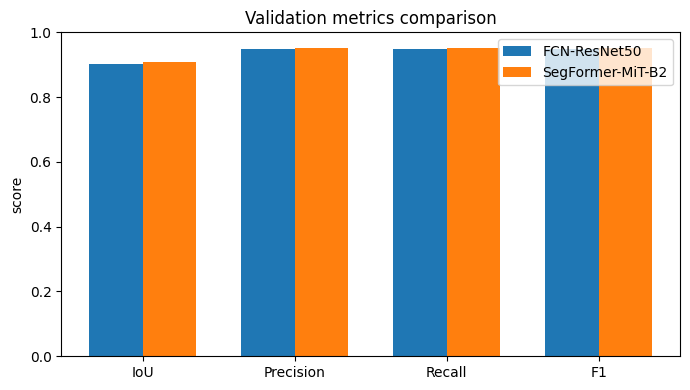

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def bar_compare(agg_a, agg_b, name_a, name_b):
    keys = ["IoU","Precision","Recall","F1"]
    a = [agg_a[k] for k in keys]
    b = [agg_b[k] for k in keys]
    x = np.arange(len(keys))
    w = 0.35

    plt.figure(figsize=(7,4))
    plt.bar(x - w/2, a, width=w, label=name_a)
    plt.bar(x + w/2, b, width=w, label=name_b)
    plt.xticks(x, keys)
    plt.ylim(0,1.0)
    plt.ylabel("score")
    plt.title("Validation metrics comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

bar_compare(agg_fcn, agg_seg, "FCN-ResNet50", "SegFormer-MiT-B2")


/tmp/ipython-input-284740020.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([iou_a, iou_b], labels=[name_a, name_b], showmeans=True)


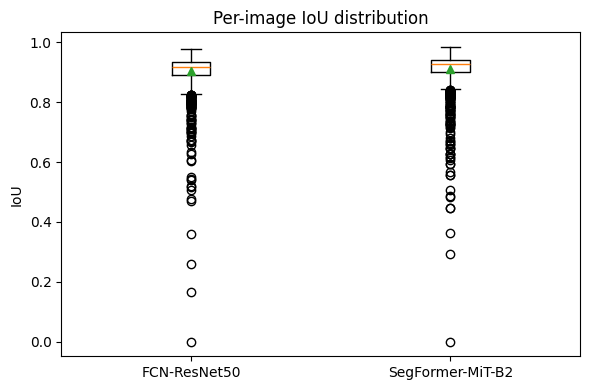

In [ ]:
import matplotlib.pyplot as plt

def boxplot_iou(perimg_a, perimg_b, name_a, name_b):
    iou_a = [d["iou"] for d in perimg_a]
    iou_b = [d["iou"] for d in perimg_b]
    plt.figure(figsize=(6,4))
    plt.boxplot([iou_a, iou_b], labels=[name_a, name_b], showmeans=True)
    plt.ylabel("IoU")
    plt.title("Per-image IoU distribution")
    plt.tight_layout()
    plt.show()

boxplot_iou(perimg_fcn, perimg_seg, "FCN-ResNet50", "SegFormer-MiT-B2")


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


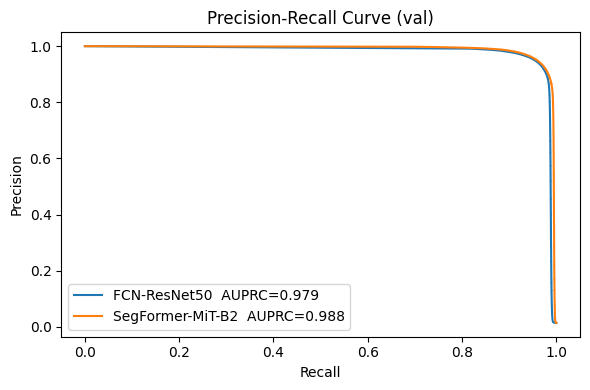

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pr(curve_a, curve_b, label_a, label_b, auprc_a, auprc_b):
    R_a, P_a = curve_a
    R_b, P_b = curve_b
    plt.figure(figsize=(6,4))
    plt.plot(R_a, P_a, label=f"{label_a}  AUPRC={auprc_a:.3f}")
    plt.plot(R_b, P_b, label=f"{label_b}  AUPRC={auprc_b:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (val)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pr(pr_fcn, pr_seg, "FCN-ResNet50", "SegFormer-MiT-B2", agg_fcn["AUPRC"], agg_seg["AUPRC"])


/tmp/ipython-input-854041672.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


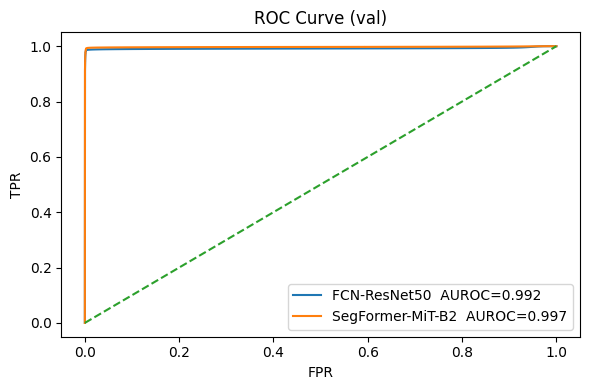

In [ ]:
import matplotlib.pyplot as plt

def plot_roc(curve_a, curve_b, label_a, label_b, auroc_a, auroc_b):
    fpr_a, tpr_a = curve_a
    fpr_b, tpr_b = curve_b
    plt.figure(figsize=(6,4))
    plt.plot(fpr_a, tpr_a, label=f"{label_a}  AUROC={auroc_a:.3f}")
    plt.plot(fpr_b, tpr_b, label=f"{label_b}  AUROC={auroc_b:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve (val)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc(roc_fcn, roc_seg, "FCN-ResNet50", "SegFormer-MiT-B2", agg_fcn["AUROC"], agg_seg["AUROC"])


In [ ]:
import pandas as pd
df = pd.DataFrame([
    {"Model":"FCN-ResNet50", **{k: agg_fcn[k] for k in ["IoU","Precision","Recall","F1","AUPRC","AUROC","N_images"]}},
    {"Model":"SegFormer-MiT-B2", **{k: agg_seg[k] for k in ["IoU","Precision","Recall","F1","AUPRC","AUROC","N_images"]}},
])
csv_path = CHECK_DIR / "metrics/summary_metrics.csv"
df.to_csv(csv_path, index=False)
df, csv_path


(              Model       IoU  Precision    Recall        F1     AUPRC  \
 0      FCN-ResNet50  0.903324   0.949906  0.947932  0.947644  0.978871   
 1  SegFormer-MiT-B2  0.909848   0.952910  0.952481  0.951257  0.987915   
 
       AUROC  N_images  
 0  0.991793      1604  
 1  0.997167      1604  ,
 PosixPath('/content/checkpoints/metrics/summary_metrics.csv'))

In [ ]:
# 1) Paste your training output text between the triple quotes
raw_log = r"""
[fcn_resnet50][001] train loss 0.1611 IoU 0.7056 | val loss 0.0622 IoU 0.8235 P 0.8707 R 0.9381 F1 0.9026 | 1.97 min
[fcn_resnet50][002] train loss 0.0533 IoU 0.8461 | val loss 0.0513 IoU 0.8468 P 0.8914 R 0.9441 F1 0.9166 | 1.75 min
[fcn_resnet50][003] train loss 0.0434 IoU 0.8724 | val loss 0.0428 IoU 0.8697 P 0.9332 R 0.9274 F1 0.9300 | 1.74 min
[fcn_resnet50][004] train loss 0.0403 IoU 0.8789 | val loss 0.0430 IoU 0.8680 P 0.9194 R 0.9394 F1 0.9290 | 1.74 min
[fcn_resnet50][005] train loss 0.0374 IoU 0.8871 | val loss 0.0469 IoU 0.8614 P 0.9236 R 0.9273 F1 0.9249 | 1.74 min
[fcn_resnet50][006] train loss 0.0355 IoU 0.8927 | val loss 0.0427 IoU 0.8725 P 0.9260 R 0.9377 F1 0.9317 | 1.74 min
[fcn_resnet50][007] train loss 0.0329 IoU 0.9003 | val loss 0.0386 IoU 0.8822 P 0.9359 R 0.9387 F1 0.9371 | 1.73 min
[fcn_resnet50][008] train loss 0.0335 IoU 0.8971 | val loss 0.0380 IoU 0.8838 P 0.9387 R 0.9377 F1 0.9380 | 1.73 min
[fcn_resnet50][009] train loss 0.0314 IoU 0.9042 | val loss 0.0395 IoU 0.8803 P 0.9359 R 0.9366 F1 0.9361 | 1.73 min
[fcn_resnet50][010] train loss 0.0279 IoU 0.9147 | val loss 0.0354 IoU 0.8931 P 0.9404 R 0.9464 F1 0.9433 | 1.74 min
[fcn_resnet50][011] train loss 0.0261 IoU 0.9198 | val loss 0.0329 IoU 0.8996 P 0.9506 R 0.9435 F1 0.9469 | 1.74 min
[fcn_resnet50][012] train loss 0.0246 IoU 0.9245 | val loss 0.0331 IoU 0.8994 P 0.9411 R 0.9529 F1 0.9469 | 1.73 min
[fcn_resnet50][013] train loss 0.0252 IoU 0.9224 | val loss 0.0361 IoU 0.8908 P 0.9501 R 0.9344 F1 0.9419 | 1.72 min
[fcn_resnet50][014] train loss 0.0251 IoU 0.9221 | val loss 0.0339 IoU 0.8976 P 0.9575 R 0.9347 F1 0.9458 | 1.72 min
[fcn_resnet50][015] train loss 0.0228 IoU 0.9295 | val loss 0.0341 IoU 0.8966 P 0.9473 R 0.9435 F1 0.9451 | 1.73 min
[fcn_resnet50][016] train loss 0.0218 IoU 0.9328 | val loss 0.0321 IoU 0.9031 P 0.9524 R 0.9457 F1 0.9490 | 1.74 min
[fcn_resnet50][017] train loss 0.0213 IoU 0.9339 | val loss 0.0330 IoU 0.9006 P 0.9514 R 0.9439 F1 0.9475 | 1.74 min
[fcn_resnet50][018] train loss 0.0205 IoU 0.9368 | val loss 0.0337 IoU 0.8993 P 0.9459 R 0.9479 F1 0.9468 | 1.74 min
[fcn_resnet50][019] train loss 0.0195 IoU 0.9399 | val loss 0.0324 IoU 0.9028 P 0.9512 R 0.9466 F1 0.9488 | 1.74 min
[fcn_resnet50][020] train loss 0.0187 IoU 0.9422 | val loss 0.0325 IoU 0.9036 P 0.9463 R 0.9523 F1 0.9492 | 1.75 min
[fcn_resnet50][021] train loss 0.0181 IoU 0.9439 | val loss 0.0327 IoU 0.9030 P 0.9479 R 0.9501 F1 0.9489 | 1.74 min
[fcn_resnet50][022] train loss 0.0175 IoU 0.9459 | val loss 0.0327 IoU 0.9034 P 0.9541 R 0.9443 F1 0.9491 | 1.74 min
[fcn_resnet50][023] train loss 0.0170 IoU 0.9473 | val loss 0.0324 IoU 0.9044 P 0.9479 R 0.9516 F1 0.9496 | 1.73 min
[fcn_resnet50][024] train loss 0.0163 IoU 0.9496 | val loss 0.0329 IoU 0.9029 P 0.9509 R 0.9469 F1 0.9488 | 1.74 min
[fcn_resnet50][025] train loss 0.0158 IoU 0.9510 | val loss 0.0328 IoU 0.9040 P 0.9424 R 0.9567 F1 0.9494 | 1.73 min
[fcn_resnet50][026] train loss 0.0154 IoU 0.9523 | val loss 0.0331 IoU 0.9034 P 0.9498 R 0.9485 F1 0.9491 | 1.73 min
[fcn_resnet50][027] train loss 0.0149 IoU 0.9541 | val loss 0.0330 IoU 0.9031 P 0.9495 R 0.9485 F1 0.9489 | 1.72 min
[fcn_resnet50][028] train loss 0.0145 IoU 0.9552 | val loss 0.0329 IoU 0.9038 P 0.9508 R 0.9479 F1 0.9493 | 1.72 min
[fcn_resnet50][029] train loss 0.0141 IoU 0.9567 | val loss 0.0326 IoU 0.9049 P 0.9487 R 0.9513 F1 0.9499 | 1.73 min
[fcn_resnet50][030] train loss 0.0136 IoU 0.9581 | val loss 0.0329 IoU 0.9048 P 0.9522 R 0.9477 F1 0.9498 | 1.73 min
[fcn_resnet50][031] train loss 0.0133 IoU 0.9592 | val loss 0.0328 IoU 0.9053 P 0.9490 R 0.9514 F1 0.9501 | 1.73 min
[fcn_resnet50][032] train loss 0.0130 IoU 0.9601 | val loss 0.0332 IoU 0.9049 P 0.9530 R 0.9470 F1 0.9499 | 1.74 min
[fcn_resnet50][033] train loss 0.0126 IoU 0.9614 | val loss 0.0331 IoU 0.9050 P 0.9552 R 0.9450 F1 0.9500 | 1.73 min
[fcn_resnet50][034] train loss 0.0123 IoU 0.9624 | val loss 0.0330 IoU 0.9056 P 0.9539 R 0.9469 F1 0.9503 | 1.74 min
[fcn_resnet50][035] train loss 0.0120 IoU 0.9632 | val loss 0.0331 IoU 0.9057 P 0.9526 R 0.9483 F1 0.9503 | 1.74 min
[fcn_resnet50][036] train loss 0.0118 IoU 0.9640 | val loss 0.0330 IoU 0.9059 P 0.9518 R 0.9494 F1 0.9505 | 1.74 min
[fcn_resnet50][037] train loss 0.0116 IoU 0.9647 | val loss 0.0331 IoU 0.9058 P 0.9504 R 0.9506 F1 0.9504 | 1.74 min
[fcn_resnet50][038] train loss 0.0113 IoU 0.9655 | val loss 0.0332 IoU 0.9059 P 0.9518 R 0.9493 F1 0.9505 | 1.74 min
[fcn_resnet50][039] train loss 0.0112 IoU 0.9662 | val loss 0.0334 IoU 0.9059 P 0.9519 R 0.9492 F1 0.9505 | 1.74 min
[fcn_resnet50][040] train loss 0.0110 IoU 0.9667 | val loss 0.0335 IoU 0.9056 P 0.9540 R 0.9468 F1 0.9503 | 1.73 min
[fcn_resnet50][041] train loss 0.0109 IoU 0.9672 | val loss 0.0334 IoU 0.9059 P 0.9525 R 0.9486 F1 0.9505 | 1.73 min
[fcn_resnet50][042] train loss 0.0107 IoU 0.9677 | val loss 0.0336 IoU 0.9056 P 0.9537 R 0.9471 F1 0.9503 | 1.73 min
[fcn_resnet50][043] train loss 0.0106 IoU 0.9681 | val loss 0.0334 IoU 0.9060 P 0.9515 R 0.9497 F1 0.9505 | 1.73 min
[fcn_resnet50][044] train loss 0.0105 IoU 0.9684 | val loss 0.0336 IoU 0.9059 P 0.9521 R 0.9490 F1 0.9504 | 1.73 min
[fcn_resnet50][045] train loss 0.0105 IoU 0.9686 | val loss 0.0337 IoU 0.9058 P 0.9539 R 0.9471 F1 0.9504 | 1.73 min
[fcn_resnet50][046] train loss 0.0104 IoU 0.9690 | val loss 0.0336 IoU 0.9059 P 0.9524 R 0.9487 F1 0.9505 | 1.73 min
[fcn_resnet50][047] train loss 0.0103 IoU 0.9690 | val loss 0.0336 IoU 0.9059 P 0.9531 R 0.9480 F1 0.9505 | 1.72 min
[fcn_resnet50][048] train loss 0.0103 IoU 0.9691 | val loss 0.0337 IoU 0.9060 P 0.9524 R 0.9488 F1 0.9505 | 1.73 min
[fcn_resnet50][049] train loss 0.0103 IoU 0.9692 | val loss 0.0336 IoU 0.9059 P 0.9530 R 0.9481 F1 0.9505 | 1.72 min
[fcn_resnet50][050] train loss 0.0103 IoU 0.9692 | val loss 0.0336 IoU 0.9060 P 0.9523 R 0.9490 F1 0.9505 | 1.73 min
[fcn_resnet50][051] train loss 0.0103 IoU 0.9693 | val loss 0.0337 IoU 0.9059 P 0.9530 R 0.9481 F1 0.9504 | 1.72 min
[fcn_resnet50][052] train loss 0.0103 IoU 0.9693 | val loss 0.0335 IoU 0.9060 P 0.9528 R 0.9485 F1 0.9505 | 1.73 min
[fcn_resnet50][053] train loss 0.0103 IoU 0.9693 | val loss 0.0335 IoU 0.9061 P 0.9532 R 0.9482 F1 0.9506 | 1.73 min
[fcn_resnet50][054] train loss 0.0103 IoU 0.9693 | val loss 0.0336 IoU 0.9060 P 0.9529 R 0.9484 F1 0.9505 | 1.74 min
[fcn_resnet50][055] train loss 0.0103 IoU 0.9693 | val loss 0.0337 IoU 0.9058 P 0.9525 R 0.9486 F1 0.9504 | 1.74 min
[fcn_resnet50][056] train loss 0.0103 IoU 0.9694 | val loss 0.0337 IoU 0.9059 P 0.9525 R 0.9486 F1 0.9505 | 1.74 min
[fcn_resnet50][057] train loss 0.0103 IoU 0.9694 | val loss 0.0337 IoU 0.9057 P 0.9528 R 0.9480 F1 0.9503 | 1.75 min
[fcn_resnet50][058] train loss 0.0102 IoU 0.9695 | val loss 0.0338 IoU 0.9057 P 0.9531 R 0.9478 F1 0.9503 | 1.75 min
[fcn_resnet50][059] train loss 0.0103 IoU 0.9694 | val loss 0.0340 IoU 0.9057 P 0.9512 R 0.9497 F1 0.9503 | 1.75 min
[fcn_resnet50][060] train loss 0.0103 IoU 0.9694 | val loss 0.0339 IoU 0.9058 P 0.9519 R 0.9490 F1 0.9504 | 1.75 min
[fcn_resnet50][061] train loss 0.0103 IoU 0.9692 | val loss 0.0339 IoU 0.9058 P 0.9512 R 0.9499 F1 0.9504 | 1.75 min
[fcn_resnet50][062] train loss 0.0103 IoU 0.9691 | val loss 0.0340 IoU 0.9059 P 0.9530 R 0.9481 F1 0.9504 | 1.74 min
[fcn_resnet50][063] train loss 0.0104 IoU 0.9688 | val loss 0.0341 IoU 0.9056 P 0.9522 R 0.9486 F1 0.9503 | 1.74 min
[segformer_mit_b2][001] train loss 0.1155 IoU 0.7781 | val loss 0.0482 IoU 0.8599 P 0.9402 R 0.9095 F1 0.9244 | 2.51 min
[segformer_mit_b2][002] train loss 0.0457 IoU 0.8655 | val loss 0.0428 IoU 0.8711 P 0.9123 R 0.9507 F1 0.9309 | 1.99 min
[segformer_mit_b2][003] train loss 0.0406 IoU 0.8780 | val loss 0.0386 IoU 0.8828 P 0.9280 R 0.9476 F1 0.9375 | 2.00 min
[segformer_mit_b2][004] train loss 0.0385 IoU 0.8838 | val loss 0.0392 IoU 0.8792 P 0.9282 R 0.9431 F1 0.9354 | 1.99 min
[segformer_mit_b2][005] train loss 0.0352 IoU 0.8935 | val loss 0.0369 IoU 0.8857 P 0.9408 R 0.9380 F1 0.9391 | 2.00 min
[segformer_mit_b2][006] train loss 0.0322 IoU 0.9015 | val loss 0.0349 IoU 0.8909 P 0.9338 R 0.9509 F1 0.9420 | 2.01 min
[segformer_mit_b2][007] train loss 0.0301 IoU 0.9074 | val loss 0.0330 IoU 0.8975 P 0.9489 R 0.9431 F1 0.9458 | 2.01 min
[segformer_mit_b2][008] train loss 0.0290 IoU 0.9110 | val loss 0.0332 IoU 0.8968 P 0.9543 R 0.9370 F1 0.9453 | 2.01 min
[segformer_mit_b2][009] train loss 0.0281 IoU 0.9133 | val loss 0.0314 IoU 0.9031 P 0.9513 R 0.9468 F1 0.9489 | 2.00 min
[segformer_mit_b2][010] train loss 0.0264 IoU 0.9185 | val loss 0.0318 IoU 0.9018 P 0.9459 R 0.9506 F1 0.9481 | 2.00 min
[segformer_mit_b2][011] train loss 0.0263 IoU 0.9188 | val loss 0.0311 IoU 0.9049 P 0.9490 R 0.9511 F1 0.9499 | 2.01 min
[segformer_mit_b2][012] train loss 0.0247 IoU 0.9236 | val loss 0.0300 IoU 0.9065 P 0.9586 R 0.9434 F1 0.9508 | 2.03 min
[segformer_mit_b2][013] train loss 0.0254 IoU 0.9212 | val loss 0.0313 IoU 0.9042 P 0.9531 R 0.9462 F1 0.9494 | 2.01 min
[segformer_mit_b2][014] train loss 0.0241 IoU 0.9255 | val loss 0.0310 IoU 0.9038 P 0.9395 R 0.9597 F1 0.9492 | 2.02 min
[segformer_mit_b2][015] train loss 0.0236 IoU 0.9269 | val loss 0.0308 IoU 0.9052 P 0.9598 R 0.9408 F1 0.9500 | 2.03 min
[segformer_mit_b2][016] train loss 0.0229 IoU 0.9291 | val loss 0.0306 IoU 0.9062 P 0.9471 R 0.9544 F1 0.9506 | 2.02 min
[segformer_mit_b2][017] train loss 0.0225 IoU 0.9298 | val loss 0.0295 IoU 0.9092 P 0.9464 R 0.9585 F1 0.9523 | 2.02 min
[segformer_mit_b2][018] train loss 0.0220 IoU 0.9317 | val loss 0.0290 IoU 0.9095 P 0.9541 R 0.9511 F1 0.9524 | 2.01 min
[segformer_mit_b2][019] train loss 0.0218 IoU 0.9321 | val loss 0.0296 IoU 0.9097 P 0.9602 R 0.9453 F1 0.9526 | 2.01 min
[segformer_mit_b2][020] train loss 0.0210 IoU 0.9347 | val loss 0.0358 IoU 0.8929 P 0.9522 R 0.9343 F1 0.9428 | 2.04 min
[segformer_mit_b2][021] train loss 0.0208 IoU 0.9355 | val loss 0.0307 IoU 0.9066 P 0.9537 R 0.9483 F1 0.9508 | 2.02 min
[segformer_mit_b2][022] train loss 0.0202 IoU 0.9373 | val loss 0.0295 IoU 0.9096 P 0.9536 R 0.9516 F1 0.9525 | 2.00 min
[segformer_mit_b2][023] train loss 0.0198 IoU 0.9381 | val loss 0.0302 IoU 0.9078 P 0.9539 R 0.9493 F1 0.9514 | 2.02 min
[segformer_mit_b2][024] train loss 0.0198 IoU 0.9381 | val loss 0.0302 IoU 0.9075 P 0.9517 R 0.9512 F1 0.9513 | 2.02 min
[segformer_mit_b2][025] train loss 0.0192 IoU 0.9403 | val loss 0.0291 IoU 0.9110 P 0.9564 R 0.9504 F1 0.9533 | 2.02 min
[segformer_mit_b2][026] train loss 0.0184 IoU 0.9426 | val loss 0.0291 IoU 0.9115 P 0.9547 R 0.9526 F1 0.9535 | 2.01 min
[segformer_mit_b2][027] train loss 0.0179 IoU 0.9438 | val loss 0.0295 IoU 0.9106 P 0.9593 R 0.9471 F1 0.9531 | 2.01 min
[segformer_mit_b2][028] train loss 0.0178 IoU 0.9445 | val loss 0.0293 IoU 0.9111 P 0.9546 R 0.9523 F1 0.9533 | 2.03 min
[segformer_mit_b2][029] train loss 0.0174 IoU 0.9458 | val loss 0.0293 IoU 0.9112 P 0.9541 R 0.9529 F1 0.9533 | 2.02 min
[segformer_mit_b2][030] train loss 0.0170 IoU 0.9470 | val loss 0.0295 IoU 0.9107 P 0.9556 R 0.9508 F1 0.9531 | 1.98 min
[segformer_mit_b2][031] train loss 0.0165 IoU 0.9482 | val loss 0.0296 IoU 0.9105 P 0.9556 R 0.9506 F1 0.9530 | 2.00 min
[segformer_mit_b2][032] train loss 0.0163 IoU 0.9490 | val loss 0.0296 IoU 0.9109 P 0.9523 R 0.9544 F1 0.9532 | 1.99 min
[segformer_mit_b2][033] train loss 0.0160 IoU 0.9499 | val loss 0.0296 IoU 0.9110 P 0.9531 R 0.9537 F1 0.9533 | 1.98 min
[segformer_mit_b2][034] train loss 0.0157 IoU 0.9509 | val loss 0.0298 IoU 0.9107 P 0.9536 R 0.9528 F1 0.9531 | 1.99 min
[segformer_mit_b2][035] train loss 0.0153 IoU 0.9520 | val loss 0.0297 IoU 0.9109 P 0.9556 R 0.9510 F1 0.9532 | 1.99 min
[segformer_mit_b2][036] train loss 0.0150 IoU 0.9530 | val loss 0.0300 IoU 0.9103 P 0.9588 R 0.9473 F1 0.9529 | 2.00 min
"""

import re, json
from pathlib import Path

CHECK_DIR = Path("/content/checkpoints"); CHECK_DIR.mkdir(exist_ok=True, parents=True)

def parse_history_from_text(raw_text: str, model_key: str):
    # matches lines like:
    # [fcn_resnet50][002] train loss 0.0950 IoU 0.6580 | val loss 0.0704 IoU 0.6722 P 0.73 R 0.64 F1 0.68 | 0.78 min
    fp = r"[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?"
    pat = re.compile(
        rf"[{re.escape(model_key)}][(?P<ep>\d+)]\s*train loss\s*(?P<tr_loss>{fp})\s*IoU\s*(?P<tr_iou>{fp})\s*\|\s*"
        rf"val loss\s*(?P<val_loss>{fp})\s*IoU\s*(?P<val_iou>{fp})\s*P\s*(?P<val_p>{fp})\s*R\s*(?P<val_r>{fp})\s*F1\s*(?P<val_f1>{fp})"
    )
    hist = []
    for m in pat.finditer(raw_text):
        hist.append({
            "epoch": int(m["ep"]),
            "train": {"loss": float(m["tr_loss"]), "iou": float(m["tr_iou"])
},
            "val": {
                "loss": float(m["val_loss"]),
                "iou": float(m["val_iou"]),
                "precision": float(m["val_p"]),
                "recall": float(m["val_r"]),
                "f1": float(m["val_f1"]),
            },
        })
    hist.sort(key=lambda x: x["epoch"])
    outp = CHECK_DIR / f"{model_key}_history.json"
    with open(outp, "w") as f:
        json.dump(hist, f, indent=2)
    print(f"Saved {len(hist)} epochs to {outp}")
    return hist

In [ ]:
# Parse both models out of the single raw_log and save to /content/checkpoints
hist_fcn = parse_history_from_text(raw_log, "fcn_resnet50")
hist_seg = parse_history_from_text(raw_log, "segformer_mit_b2")

print(len(hist_fcn), "epochs parsed for FCN")
print(len(hist_seg), "epochs parsed for SegFormer")

Saved 63 epochs to /content/checkpoints/fcn_resnet50_history.json
Saved 36 epochs to /content/checkpoints/segformer_mit_b2_history.json
63 epochs parsed for FCN
36 epochs parsed for SegFormer


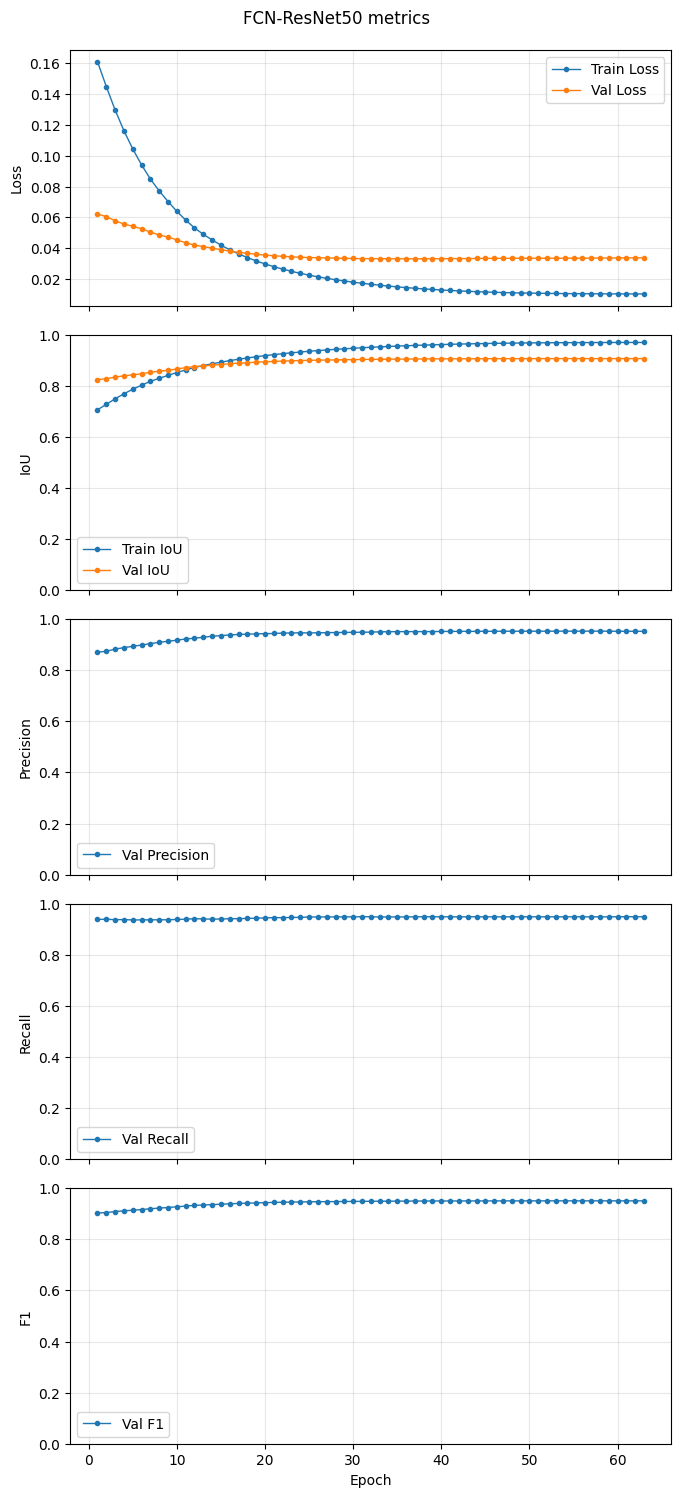

Saved: /content/checkpoints/fcn_resnet50_metrics_curves.png


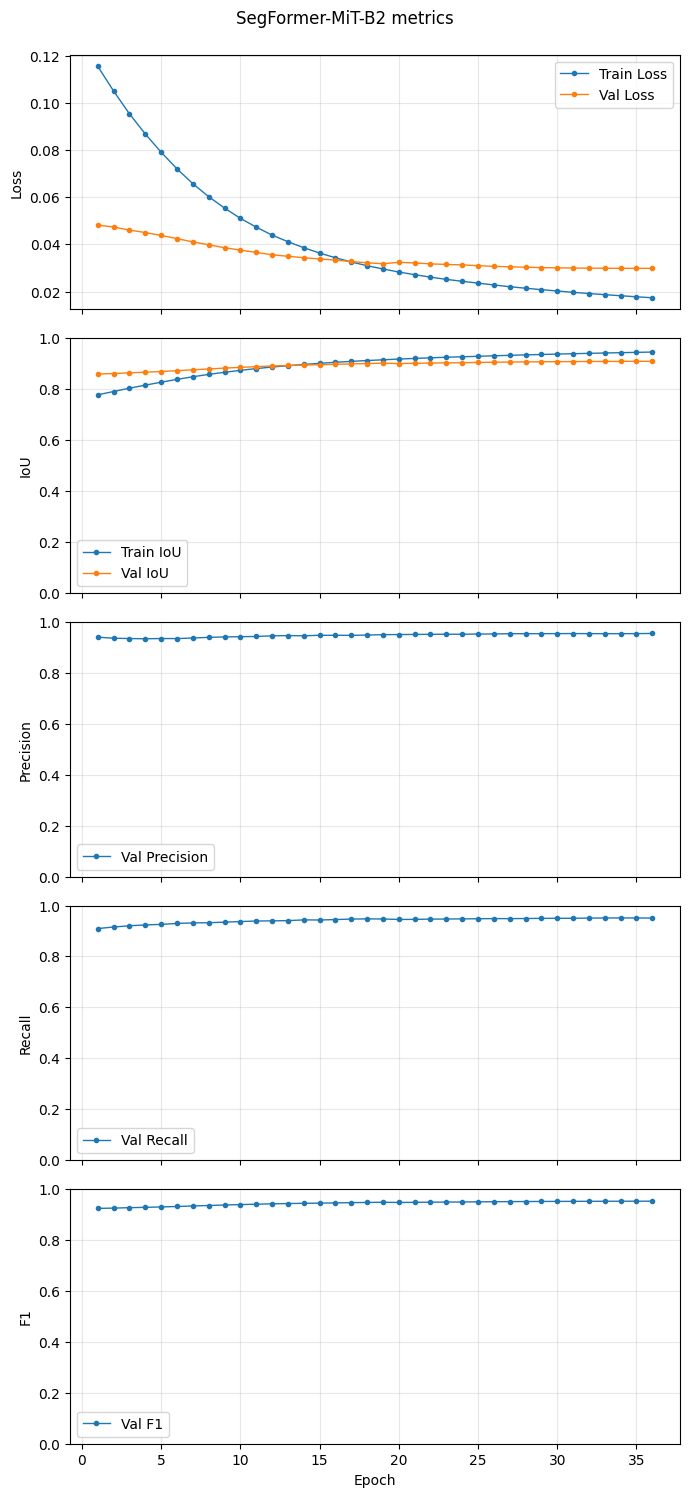

Saved: /content/checkpoints/segformer_mit_b2_metrics_curves.png


In [ ]:
# Robust plotter
import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

CHECK_DIR = Path("/content/checkpoints")

def _smooth_nan(arr, alpha=0.2):
    if alpha is None: return arr
    arr = np.asarray(arr, dtype=float); out = np.copy(arr); m = np.nan
    for i, x in enumerate(arr):
        if np.isnan(x): out[i] = np.nan
        else:
            m = x if np.isnan(m) else alpha*x + (1-alpha)*m
            out[i] = m
    return out

def _series(history, split, key):
    vals = []
    for h in history:
        v = h.get(split, {}).get(key, None)
        vals.append(np.nan if v === None else float(v))
    return np.array(vals, dtype=float)

def load_history(model_key: str):
    p = CHECK_DIR / f"{model_key}_history.json"
    with open(p) as f:
        return json.load(f)

def plot_metrics(history, model_label: str, save_prefix: str, smooth_alpha=0.2):
    metrics = [("loss","Loss"), ("iou","IoU"), ("precision","Precision"),
               ("recall","Recall"), ("f1","F1")]
    epochs = [h["epoch"] for h in history]
    fig, axes = plt.subplots(len(metrics), 1, figsize=(7, 3*len(metrics)), sharex=True)
    for ax, (k, title) in zip(axes, metrics):
        tr = _series(history, "train", k)
        vl = _series(history, "val",   k)
        if np.isfinite(tr).any():
            ax.plot(epochs, _smooth_nan(tr, smooth_alpha), label=f"Train {title}", marker="o", ms=3, lw=1)
        if np.isfinite(vl).any():
            ax.plot(epochs, _smooth_nan(vl, smooth_alpha), label=f"Val {title}", marker="o", ms=3, lw=1)
        ax.set_ylabel(title)
        if k != "loss":
            ax.set_ylim(0, 1.0)
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")
    axes[-1].set_xlabel("Epoch")
    fig.suptitle(f"{model_label} metrics", y=0.995)
    fig.tight_layout()
    out = f"{save_prefix}_metrics_curves.png"
    plt.savefig(out, dpi=180); plt.show()
    print("Saved:", out)

# Load the saved JSONs and plot
hist_fcn = load_history("fcn_resnet50")
plot_metrics(hist_fcn, "FCN-ResNet50", str(CHECK_DIR / "fcn_resnet50"), smooth_alpha=0.15)

hist_seg = load_history("segformer_mit_b2")
plot_metrics(hist_seg, "SegFormer-MiT-B2", str(CHECK_DIR / "segformer_mit_b2"), smooth_alpha=0.15)

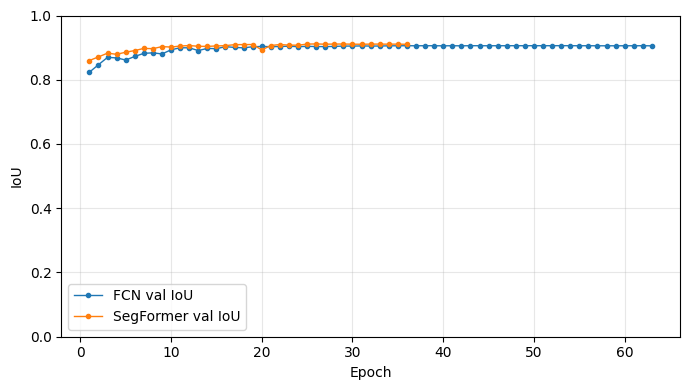

In [ ]:
# Compare validation IoU on a single axis
import json, matplotlib.pyplot as plt
with open(CHECK_DIR / "fcn_resnet50_history.json") as f: hf = json.load(f)
with open(CHECK_DIR / "segformer_mit_b2_history.json") as f: hs = json.load(f)

ep_f = [h["epoch"] for h in hf]; iou_f = [h["val"]["iou"] for h in hf]
ep_s = [h["epoch"] for h in hs]; iou_s = [h["val"]["iou"] for h in hs]

plt.figure(figsize=(7,4))
plt.plot(ep_f, iou_f, label="FCN val IoU", marker="o", ms=3, lw=1)
plt.plot(ep_s, iou_s, label="SegFormer val IoU", marker="o", ms=3, lw=1)
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.ylim(0,1.0); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(str(CHECK_DIR / "compare_val_iou.png"), dpi=180); plt.show()


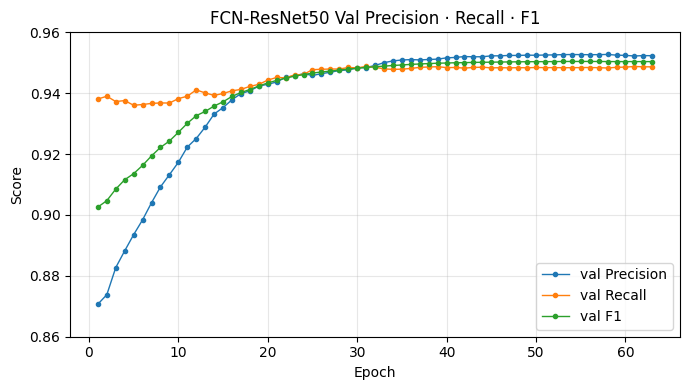

Saved: /content/checkpoints/fcn_resnet50_val_PRF1_auto.png


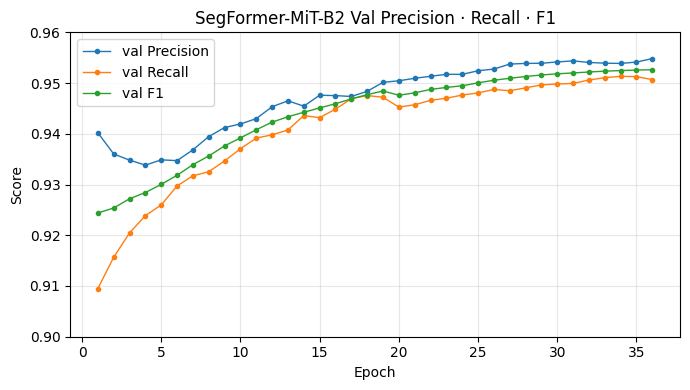

Saved: /content/checkpoints/segformer_mit_b2_val_PRF1_auto.png


In [ ]:
# Advanced version: automatically crop upper and lower limits by quantile, no empty space at the bottom
import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

CHECK_DIR = Path("/content/checkpoints")

def _load_history(model_key): return json.load(open(CHECK_DIR / f"{model_key}_history.json"))

def _series(history, split, key):
    out=[]
    for h in history:
        v = h.get(split, {}).get(key, None)
        out.append(np.nan if v is None else float(v))
    return np.asarray(out, dtype=float)

def _smooth(arr, alpha=0.15):
    if alpha is None: return arr
    arr = np.asarray(arr, dtype=float); out = arr.copy(); m = np.nan
    for i, x in enumerate(arr):
        if np.isnan(x): continue
        m = x if np.isnan(m) else alpha*x + (1-alpha)*m
        out[i] = m
    return out

def plot_prf1_oneplot(history, model_label: str, save_prefix: str,
                      split="val", smooth_alpha=0.15,
                      y_floor=None, y_ceiling=None,
                      auto_quantiles=(5, 99), pad=0.003, percent_ticks=False):
    ep = [h["epoch"] for h in history]
    P  = _smooth(_series(history, split, "precision"), smooth_alpha)
    R  = _smooth(_series(history, split, "recall"),    smooth_alpha)
    F1 = _smooth(_series(history, split, "f1"),        smooth_alpha)

    # Data-driven upper and lower limits (if not manually specified)
    vals = np.concatenate([v[~np.isnan(v)] for v in [P, R, F1] if np.isfinite(v).any()])
    if y_floor is None or y_ceiling is None:
        q_low, q_high = auto_quantiles
        lo = np.percentile(vals, q_low)  if y_floor   is None else y_floor
        hi = np.percentile(vals, q_high) if y_ceiling is None else y_ceiling
        y0 = max(0.0, float(lo) - pad)
        y1 = min(1.0, float(hi) + pad)
    else:
        y0, y1 = y_floor, y_ceiling

    plt.figure(figsize=(7,4))
    if np.isfinite(P).any():  plt.plot(ep, P,  label=f"{split} Precision", marker="o", ms=3, lw=1)
    if np.isfinite(R).any():  plt.plot(ep, R,  label=f"{split} Recall",    marker="o", ms=3, lw=1)
    if np.isfinite(F1).any(): plt.plot(ep, F1, label=f"{split} F1",        marker="o", ms=3, lw=1)
    plt.ylim(y0, y1)
    plt.xlabel("Epoch"); plt.ylabel("Score")
    plt.title(f"{model_label} {split.capitalize()} Precision · Recall · F1")
    if percent_ticks:
        from matplotlib.ticker import PercentFormatter
        plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    out_path = f"{save_prefix}_{split}_PRF1_auto.png"
    plt.savefig(out_path, dpi=180); plt.show()
    print("Saved:", out_path)

# Usage 1: Fully automatic, using 5%~99% quantile range (bottom almost not empty)
# FCN: lower limit 0.86, upper limit can be 0.96 (tighter) or removed to keep at 1.0
hist_fcn = _load_history("fcn_resnet50")
plot_prf1_oneplot(
    history=hist_fcn,
    model_label="FCN-ResNet50",
    save_prefix=str(CHECK_DIR / "fcn_resnet50"),
    split="val",
    y_floor=0.86,           # <-- Desired lower limit
    y_ceiling=0.96          # Optional. Remove this line to keep at 1.0
)

# SegFormer: lower limit 0.90
hist_seg = _load_history("segformer_mit_b2")
plot_prf1_oneplot(
    history=hist_seg,
    model_label="SegFormer-MiT-B2",
    save_prefix=str(CHECK_DIR / "segformer_mit_b2"),
    split="val",
    y_floor=0.90,
    y_ceiling=0.96          # Optional
)